In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

In [2]:
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

Using TensorFlow backend.


In [3]:
philips_c1_images=np.load('x_data.npy')
philips_c1_masks=np.load('y_data.npy')

In [4]:
philips_c1_images.shape

(134, 256, 256, 1)

In [5]:
philips_c1_images=np.reshape(philips_c1_images,(134,256,256))

In [10]:
philips_c1_masks=np.reshape(philips_c1_masks,(134,256,256))

In [11]:
philips_c1_masks.shape

(134, 256, 256)

In [7]:
philips_c1_images.shape

(134, 256, 256)

In [8]:
type(philips_c1_masks)

numpy.ndarray

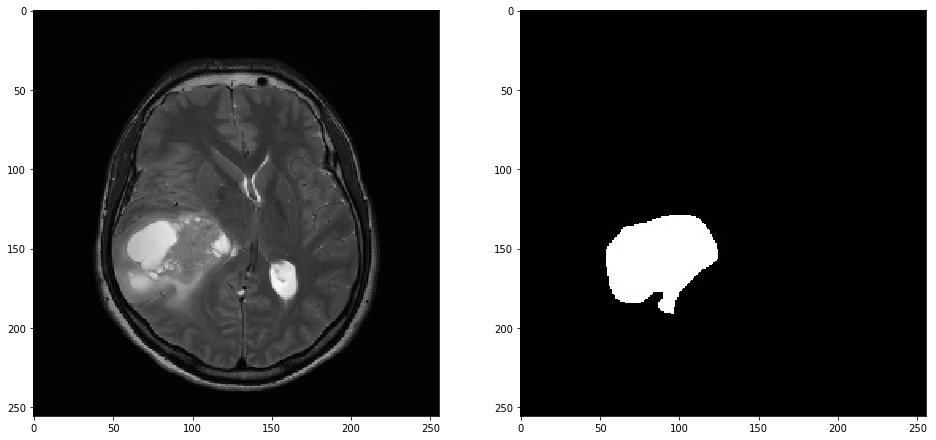

In [13]:
fig , ax =plt.subplots(1,2,figsize=(16,16))
ax[0].imshow(philips_c1_images[32],cmap='gray')
ax[1].imshow(philips_c1_masks[32],cmap='gray')
plt.show()

In [14]:
philips_c2_images=np.load('x_data_philips_c2_images.npy')
philips_c2_masks=np.load('y_data_philips_c2_mask.npy')

In [15]:
philips_c2_masks.shape

(56, 256, 256)

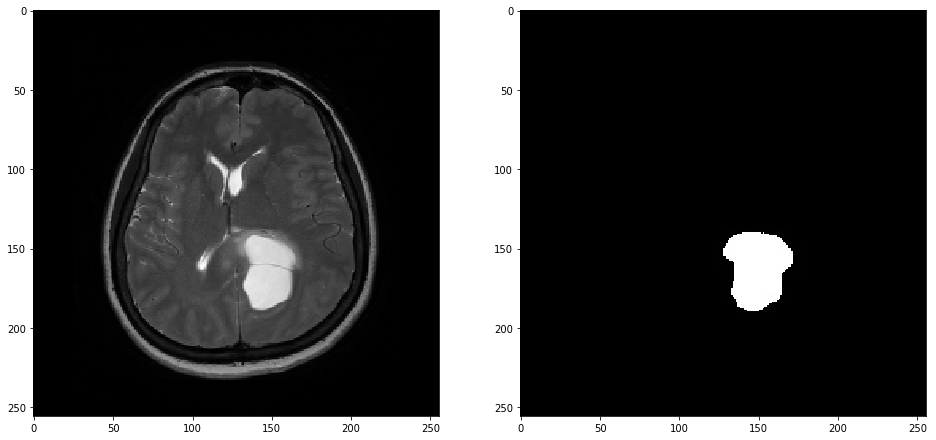

In [16]:
fig , ax =plt.subplots(1,2,figsize=(16,16))
ax[0].imshow(philips_c2_images[32],cmap='gray')
ax[1].imshow(philips_c2_masks[32],cmap='gray')
plt.show()

In [17]:
siemens_c1_images=np.load('x_data_siemens_c1_images.npy')
siemens_c1_masks=np.load('y_data_siemens_c1_mask.npy')

In [18]:
siemens_c1_images.shape

(140, 256, 256)

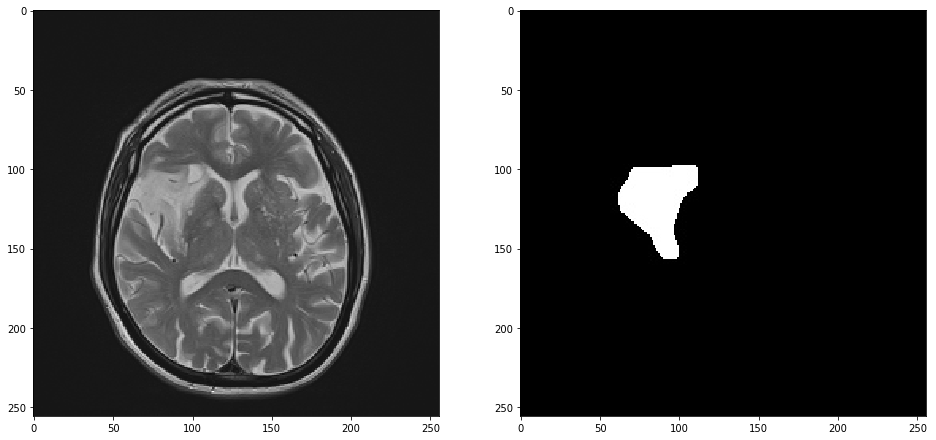

In [19]:
fig , ax =plt.subplots(1,2,figsize=(16,16))
ax[0].imshow(siemens_c1_images[32],cmap='gray')
ax[1].imshow(siemens_c1_masks[32],cmap='gray')
plt.show()

In [20]:
siemens_c2_images=np.load('x_data_siemens_c2_images.npy')
siemens_c2_masks=np.load('y_data_siemens_c2_mask.npy')

In [21]:
siemens_c2_images.shape

(119, 256, 256)

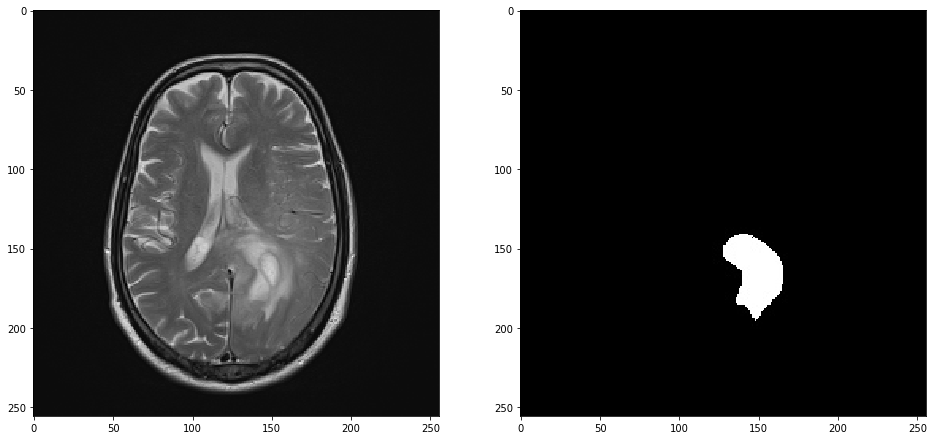

In [22]:
fig , ax =plt.subplots(1,2,figsize=(16,16))
ax[0].imshow(siemens_c2_images[32],cmap='gray')
ax[1].imshow(siemens_c2_masks[32],cmap='gray')
plt.show()

In [23]:
res1=np.concatenate([philips_c1_images,philips_c2_images,siemens_c1_images,siemens_c2_images],axis=0)

In [24]:
res2=np.concatenate([philips_c1_masks,philips_c2_masks,siemens_c1_masks,siemens_c2_masks],axis=0)

In [25]:
res1.shape

(449, 256, 256)

In [26]:
res2.shape

(449, 256, 256)

In [27]:
print (res1.max())
print (res1.min())

1.0
0.0


In [28]:
print (res2.max())
print (res2.min())

1.0
0.0


In [30]:
#res1=res1[:,:,:,np.newaxis]
#res2=res2[:,:,:,np.newaxis]

In [31]:
res2.shape

(449, 256, 256, 1)

In [32]:
res1_train, res1_val, res2_train, res2_val = train_test_split(res1, res2, test_size = 0.5)

In [33]:
plt.imshow(res1_train[0,:,:,0],cmap='gray')

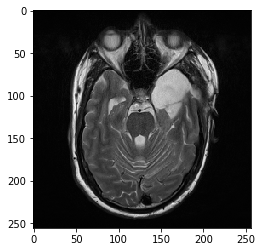

In [34]:
plt.show()

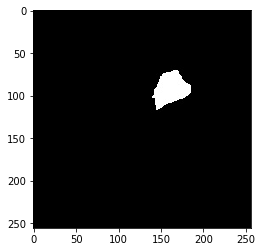

In [35]:
plt.imshow(res2_train[0,:,:,0],cmap='gray')
plt.show()

In [36]:
vr=res1_train[0] * res2_train[0]

In [37]:
vr.shape

(256, 256, 1)

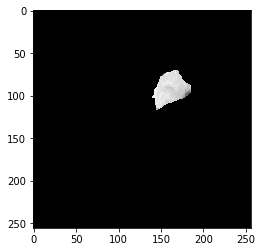

In [38]:
plt.imshow(vr[:,:,0],cmap='gray')
plt.show()

In [39]:
def my_generator(images, masks, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(images, images, batch_size, seed=42)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(masks, masks, batch_size, seed=42)
    while True:
        images_batch, _ = data_generator.next()
        masks_batch, _ = mask_generator.next()
        yield images_batch, masks_batch

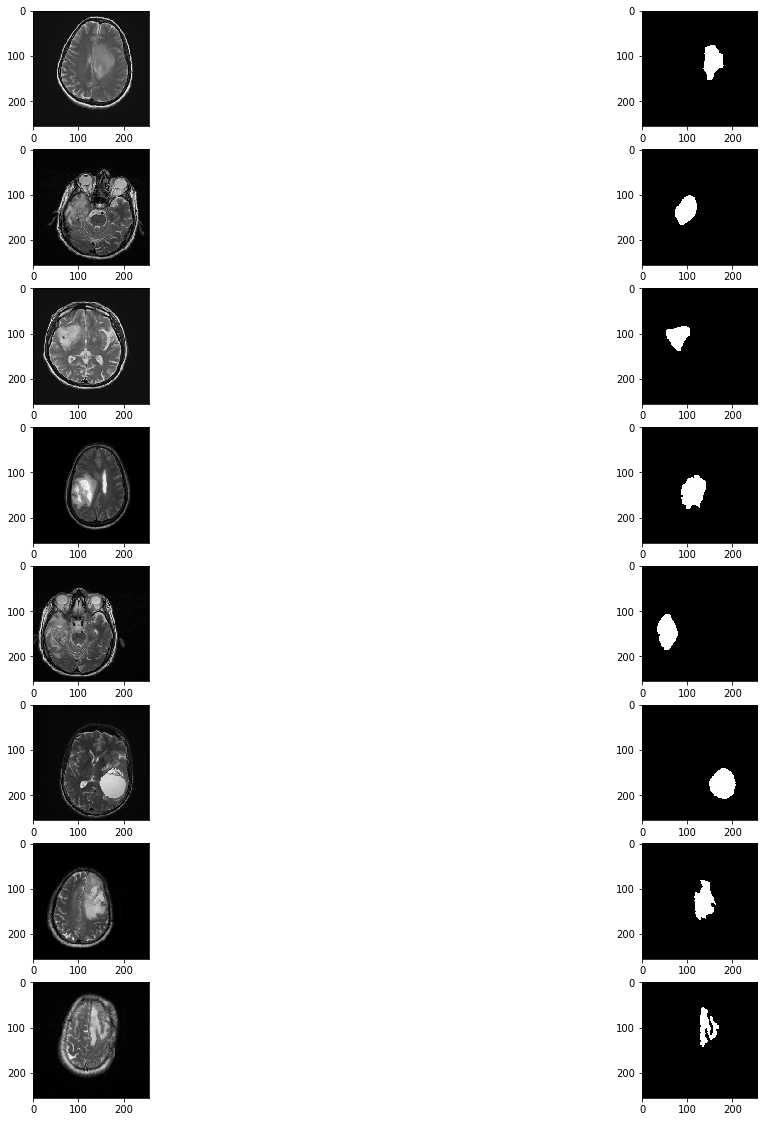

In [40]:
image_batch, mask_batch = next(my_generator(res1_train, res2_train, 8))
fix, ax = plt.subplots(8,2, figsize=(20,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0],cmap='gray')
    ax[i,1].imshow(mask_batch[i,:,:,0],cmap='gray')
plt.show()

In [40]:
input_layer = Input(shape=res1_train.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

In [44]:
inputs = Input(shape=res1_train.shape[1:])
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model1 = Model(inputs=[inputs], outputs=[conv10])
model1.compile(optimizer=Adam(lr=1e-2), loss='binary_crossentropy', metrics=[dice_coef])


In [42]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [43]:
def dice_loss(y_true,y_pred):
    return -dice_coef(y_true,y_pred)

In [100]:
model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])

In [45]:
weight_saver = ModelCheckpoint('final1.h5', monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.1 ** x)

In [102]:
hist = model.fit_generator(my_generator(res1_train, res2_train, 8),
                           steps_per_epoch = 200,
                           validation_data = (res1_val, res2_val),
                           epochs=10, verbose=1,
                           callbacks = [weight_saver, annealer])

Epoch 1/10
  5/200 [..............................] - ETA: 531s - loss: 0.0466 - dice_coef: 0.6383

KeyboardInterrupt: 

In [47]:
print (model1.summary())
checkpoint = ModelCheckpoint('final2.h5', monitor='val_loss', save_best_only=True)
    
model1.fit(res1,res2,batch_size=32,nb_epoch=20,verbose=1,validation_split=0.2,callbacks=[checkpoint])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 256, 256, 1)   0                                            
____________________________________________________________________________________________________
conv2d_20 (Conv2D)               (None, 256, 256, 32)  320         input_2[0][0]                    
____________________________________________________________________________________________________
conv2d_21 (Conv2D)               (None, 256, 256, 32)  9248        conv2d_20[0][0]                  
____________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)   (None, 128, 128, 32)  0           conv2d_21[0][0]                  
___________________________________________________________________________________________

C:\Users\Srinjay\Miniconda3\envs\work\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


256/359 [====================>.........] - ETA: 154s - loss: 0.5944 - dice_coef: 1.3036e-12

KeyboardInterrupt: 

In [103]:
model.load_weights('final1.h5')

In [ ]:
model1.load_weights('final2.h5')

In [55]:
y_hat = model.predict(res1_val)
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(res1_val[0,:,:,0], cmap='gray')
ax[1].imshow(res2_val[0,:,:,0],cmap='gray')
ax[2].imshow(y_hat[0,:,:,0],cmap='gray')

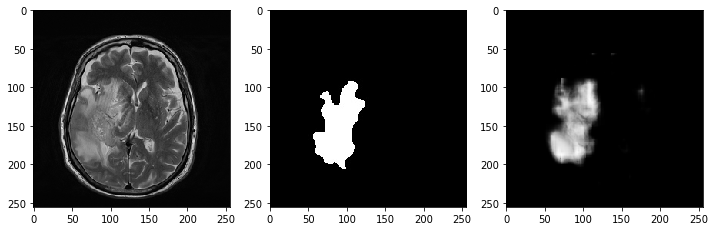

In [56]:
plt.show()

In [57]:
y_hat[0].min()

5.6945818e-34

In [58]:
result=y_hat[0]* res1_val[0]

In [59]:
result.shape

(256, 256, 1)

In [71]:
result1=cv2.medianBlur(result,3)

In [72]:
result1.shape

(256, 256)

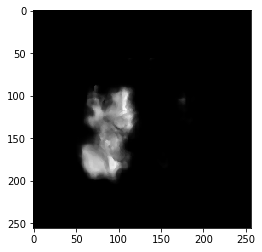

In [73]:
plt.imshow(result1,cmap='gray')
plt.show()

In [76]:
sub=res1_val[0]-result

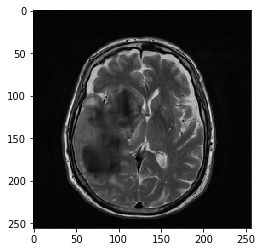

In [77]:
plt.imshow(sub[:,:,0],cmap='gray')
plt.show()